In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, interpolate

from lmfit import Model

from tqdm.auto import tqdm

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Function definitions

In [3]:
def standardize_within_conditions(df):
    """
    Find linear transformation that lines up data from manual and automatic
    tiration runs to allow a global fit to all data. 
    """
    
    # Model for linear transformation of datasets
    def _line(x,m,b):
        return m*x+b
    
    # Work on a copy
    df = df.copy()
    
    # New columns we're going to populate
    df["include_in_fit"] = True
    df["reg_signal"] = 0.0
    df["weight"] = 1.0
    df["ffx"] = np.nan
    
    conditions = set(list(zip(df.variant,df.calcium_conc)))
    for c in conditions:
        
        # Get mask to pull out only experiments that match this condition
        mask = np.logical_and(df.variant == c[0],
                              np.isclose(df.calcium_conc,c[1]))
        
        # Get matching experiments
        experiments = df.loc[mask,:]
        
        # Get the manual experiment that hits the highest urea concentration
        # as our reference experiment.
        manual = experiments.loc[experiments.expt_type == "manual",:]
        ref_biorep = manual.biorep.iloc[np.argmax(manual.urea)]
        ref_expt = experiments.loc[experiments.biorep == ref_biorep,:]
        
        # Go over all bioreps
        all_bioreps = np.unique(experiments.biorep)
        for i in all_bioreps:
            
            # Get this biorep
            this_expt = experiments.loc[experiments.biorep == i,:]
            
            # Mask that points to this bio rep
            biorep_mask = np.logical_and(mask,df.biorep == i)
            
            # Assign a weight of 1/num_points to this biorep to appropriately
            # weight between experiments during global fit. This makes sure the
            # automatic titrations -- which have a ton of points -- don't 
            # dominate the regression.
            df.loc[biorep_mask,"weight"] = 1/len(this_expt)
            
            # Don't rescale ref -- we're rescaling to it
            if i == ref_biorep:
                df.loc[biorep_mask,"reg_signal"] = this_expt.cd_signal
                continue
            
            # Figure out which dataset we're having to interpolate. Either this
            # experiment or the reference. 
            if np.max(this_expt.urea) < np.max(ref_expt.urea):
                
                # Generate interpolator and urea values to use inside the
                # interpolator. (Interpolate ref_expt)
                f = interpolate.interp1d(ref_expt.urea, ref_expt.cd_signal,
                                         kind='cubic',fill_value="extrapolate")
                                
                # Fit a line between the interpolated ref_expt and experiment
                popt, pcov = optimize.curve_fit(_line,
                                                f(this_expt.urea),
                                                this_expt.cd_signal,
                                                p0=[1, -1600000])
                
                # Transform this_expt signal to match the ref_expt
                new_y = this_expt.cd_signal/popt[0] - popt[1]
                
            else:
                
                # Generate interpolator and urea values to use inside the
                # interpolator. (Interpolate this_expt)
                f = interpolate.interp1d(this_expt.urea, this_expt.cd_signal,
                                         kind='cubic',fill_value="extrapolate")
                
                popt, pcov = optimize.curve_fit(_line,
                                                f(ref_expt.urea),
                                                ref_expt.cd_signal,
                                                p0=[1, -1600000])
                
                new_y = this_expt.cd_signal*popt[0] + popt[1]
                                
            # Put transformed cd_signal into "signal" column for this biorep            
            df.loc[biorep_mask,"reg_signal"] = new_y
            
        
        ignore_mask = np.logical_and(mask,np.isclose(df.urea,0))
        df.loc[ignore_mask,"include_in_fit"] = False
                
        norm_mask = np.logical_and(mask,df.include_in_fit)
        norm_sig = df.loc[norm_mask,"reg_signal"]
                            
        a = np.min(norm_sig)
        b = np.max(norm_sig)

        df.loc[mask,"ffx"] = 1 - (df.loc[mask,"reg_signal"] - a)/(b - a)
    
    
    columns = ['variant','calcium_conc','biorep','expt_type',
               'urea','ffx','weight','include_in_fit','reg_signal','cd_signal',
               'date','file','prot_conc','temp']
    
    return df.loc[:,columns]

def fit_melt(df,variant,calcium_conc,
             m_value=None,fig=None,ax=None,
             gen_plot=True,color="black"):
    """
    Fit chemical denaturation data for a given variant and calcium condition.
    
    df: data frame with regularized values
    variant: protein variant (string)
    calicum_conc: calcium_conc
    m_value: m-value to use. if None, float
    fig, ax: matplotlib objects to use for fit. if None, create
    gen_plot: generate a plot
    color: color for points/fit
    """
    
    def _melt(urea, nat_b, nat_m, den_b, den_m, dG, m_value):
        
        native = nat_b + nat_m*urea
        denat = den_b + den_m*urea
        K = np.exp(-(dG - m_value*urea)/(0.001987*298.15))
        
        return native + denat*K/(1+K)
    
    # Extract data to fit
    mask = np.logical_and(df.variant == variant,
                          df.calcium_conc == calcium_conc)
    df = df.loc[np.logical_and(mask,df.include_in_fit),:]
    
    # Decide whether or not to vary m-value based on whether a value is 
    # specified as an argument. 
    if m_value is None:
        m_value = 1
        vary_m_value = True
    else:
        vary_m_value = False
    
    # Set up fit object
    melt_model = Model(_melt)
    params = melt_model.make_params(m_value=m_value, nat_b=1, nat_m=0, den_b=0, den_m=0, dG=5)

    # Float/do not float m value
    params["m_value"].vary = vary_m_value
    params["nat_m"].min = -0.08
    params["nat_m"].max = 0.08

    # Do fit
    fit = melt_model.fit(df.ffx, params, urea=df.urea, weights=df.weight) 

    # calculate rmsd for fit
    rmsd = np.sqrt(np.sum(fit.residual**2)/fit.ndata)
    
    # Extract the fit values
    dG = fit.values["dG"]
    
    # error
    if fit.covar is None:
        dG_err = np.nan
    else:
        dG_index = list(fit.params.keys()).index("dG")
        dG_err = fit.covar[dG_index][dG_index]
    m = fit.values["m_value"]
    Cm = dG/m
    Cm_err = dG_err*m

    # Create human-readable output
    summary_data = pd.DataFrame({"variant":[variant],
                                 "calcium_conc":[calcium_conc],
                                 "dG":[dG],
                                 "dG_err":[dG_err],
                                 "m":[m],
                                 "Cm":[Cm],
                                 "Cm_err":[Cm_err],
                                 "rmsd":[rmsd]})

    if gen_plot:
        
        if ax is None:
            fig, ax = plt.subplots(1,figsize=(6,6))
    
        for i in np.unique(df.biorep):

            expt = df.loc[df.biorep == i,:]
            
            if expt.expt_type.iloc[0] == "manual":
                point_fmt = {"ms":20,"mfc":"none","mec":color}
            else:
                point_fmt = {"ms":20,"mfc":color,"mec":color}

            ax.plot(expt.urea,expt.ffx,".",**point_fmt)

        urea_span = np.linspace(0,np.max(df.urea)*1.05,100)

        fit_y = _melt(urea_span,
                      fit.values["nat_b"],
                      fit.values["nat_m"],
                      fit.values["den_b"],
                      fit.values["den_m"],
                      fit.values["dG"],
                      fit.values["m_value"])

        ax.plot(urea_span,fit_y,"-",lw=3,color=color)
        
        ax.set_xlabel("[urea] (M)")
        ax.set_ylabel("fraction signal")
    
    return summary_data, fig, ax

def global_fit_m_value(df,m_to_test=np.arange(0.05,3.05,0.05)):
    """
    Identify an m-value that is optimal across all variant/calcium in the 
    dataframe. Samples across m-values, then fits each variant/calcium 
    condition individually. Identifies m-value that minimizes sum of rmsd
    across conditions. 
    """
    
    # Get all conditions in df
    combos = set(list(zip(df.variant,df.calcium_conc)))

    # Sample over possible m-values
    all_rmsd = []
    all_results = []
    for m_value in tqdm(m_to_test):
        
        this_m = []
        for c in combos:
            s, _, _ = fit_melt(df,c[0],c[1],m_value=m_value,gen_plot=False)
            this_m.append(s)

        all_results.extend(this_m)

        all_rmsd.append(np.sum(pd.concat(this_m).rmsd))

    m_search_df = pd.concat(all_results,ignore_index=True)

    fig, ax = plt.subplots(1,figsize=(6,5))
    ax.plot(m_to_test,all_rmsd,lw=3)
    ax.set_xlabel("m-value (kcal/mol*M)")
    ax.set_ylabel("global rmsd")
    
    best_m = m_to_test[np.argmin(all_rmsd)]
    
    return best_m, m_search_df, fig, ax

### Read raw data and regularize

In [4]:
raw_df = pd.read_csv("raw-melt-data.csv")
df = standardize_within_conditions(raw_df)

/Users/harmsm/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### Find the best m-value across all experiments

  0%|          | 0/60 [00:00<?, ?it/s]

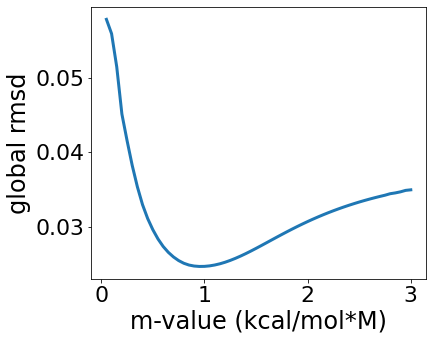

In [5]:
best_m, s, fig, ax = global_fit_m_value(df)
plt.savefig("figure_sxx_global-rmsd-vs-m-value.pdf")

### Fig 2B, 2C (fit all chemical denaturation data)

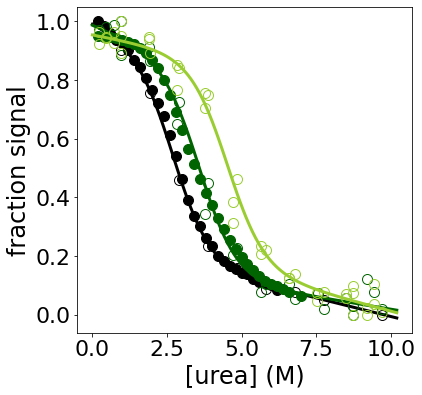

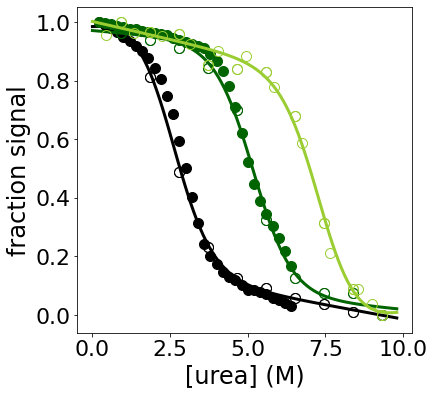

,variant,calcium_conc,dG,dG_err,m,Cm,Cm_err,rmsd
0,hS100A9,0.0000,2.600847,0.005271,0.95,2.737734,0.005008,0.000606
0,hS100A9,0.0005,3.456928,0.016129,0.95,3.638871,0.015322,0.001979
0,hS100A9,0.0050,4.286158,0.023771,0.95,4.511746,0.022582,0.002772
0,hS100A9/M63F,0.0000,2.416805,0.006384,0.95,2.544005,0.006065,0.001041
0,hS100A9/M63F,0.0005,4.908849,0.003785,0.95,5.167209,0.003595,0.001381
0,hS100A9/M63F,0.0050,7.006999,0.026295,0.95,7.375788,0.024981,0.002336
0,hS100A9/F37L,0.0000,2.929658,0.013198,0.95,3.083850,0.012538,0.001316
0,hS100A9/F37L,0.0005,3.088716,0.072243,0.95,3.251280,0.068631,0.004099
0,hS100A9/F37L,0.0050,3.364329,0.020638,0.95,3.541399,0.019606,0.002815
0,hS100A9/F37L/M63F,0.0000,2.918977,0.019047,0.95,3.072607,0.018095,0.001481


In [6]:

m_value = best_m
    
# Fit hS100A9
s1, fig, ax = fit_melt(df,"hS100A9",0,m_value=m_value,color="black")
s2, _, _ = fit_melt(df,"hS100A9",0.0005,m_value=m_value,fig=fig,ax=ax,color="darkgreen")
s3, _, _ = fit_melt(df,"hS100A9",0.005,m_value=m_value,fig=fig,ax=ax,color="yellowgreen")
wt = pd.concat([s1,s2,s3])
fig.savefig("figure_2b.pdf")
plt.show()

# Fit hS100A9/M63F
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0,m_value=m_value,color="black")
s2, _, _ = fit_melt(df,"hS100A9/M63F",0.0005,m_value=m_value,fig=fig,ax=ax,color="darkgreen")
s3, _, _ = fit_melt(df,"hS100A9/M63F",0.005,m_value=m_value,fig=fig,ax=ax,color="yellowgreen")
m63f = pd.concat([s1,s2,s3])
fig.savefig("figure_2c.pdf")
plt.show()

# Fit hS100A9/F37L
s1, _, _ = fit_melt(df,"hS100A9/F37L",0,m_value=m_value,gen_plot=False)
s2, _, _ = fit_melt(df,"hS100A9/F37L",0.0005,m_value=m_value,gen_plot=False)
s3, _, _ = fit_melt(df,"hS100A9/F37L",0.005,m_value=m_value,gen_plot=False)
f37l = pd.concat([s1,s2,s3])

# Fit hS100A9/F37L/M63F
s1, _, _ = fit_melt(df,"hS100A9/F37L/M63F",0,m_value=m_value,gen_plot=False)
s2, _, _ = fit_melt(df,"hS100A9/F37L/M63F",0.0005,m_value=m_value,gen_plot=False)
s3, _, _ = fit_melt(df,"hS100A9/F37L/M63F",0.005,m_value=m_value,gen_plot=False)
double = pd.concat([s1,s2,s3])

fit_results = pd.concat([wt,m63f,f37l,double])
fit_results.to_csv("table_sxx.csv")
fit_results

### Fig 5A (Phe/Phe mutant cycle, 0 mM Ca2+)

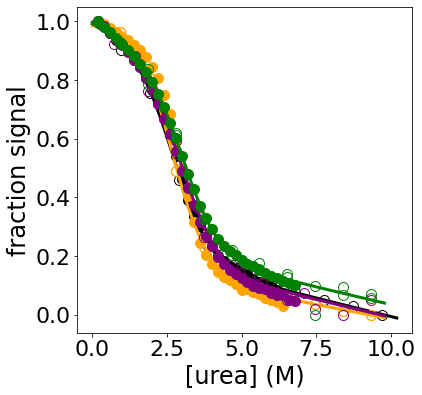

In [7]:
s1, fig, ax = fit_melt(df,"hS100A9",0,m_value=m_value,color="black")
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0,m_value=m_value,color="orange",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L",0,m_value=m_value,color="purple",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L/M63F",0,m_value=m_value,color="green",fig=fig,ax=ax)
plt.savefig("figure-5a.pdf")

### Fig 5B (Phe/Phe mutant cycle, 5 mM Ca2+)

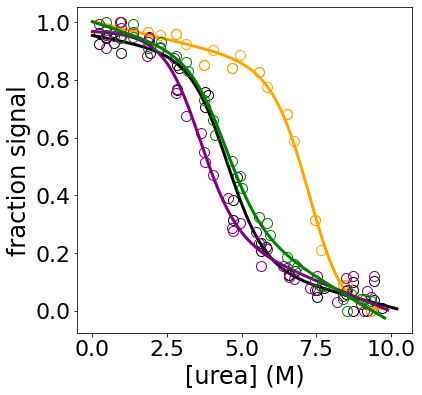

In [8]:
s1, fig, ax = fit_melt(df,"hS100A9",0.005,m_value=m_value,color="black")
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0.005,m_value=m_value,color="orange",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L",0.005,m_value=m_value,color="purple",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L/M63F",0.005,m_value=m_value,color="green",fig=fig,ax=ax)
plt.savefig("figure-5b.pdf")